Notebook 5: In which we use fully-connected neural networks to identify fish, do a lousy job and ask you to improve upon it by using convolutional neural networks (CNN)
------------------------------------------------------------------------------------------
We will use miniCARP, a restricted version of a library of fish images prepared by the lab as part of __[idtracker.ai](http://idtracker.ai)__ paper  

In [17]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Callable
import gdown

In [2]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: GPU is not enabled in this environment.")
    else:
        print("GPU is enabled.")
    return device


DEVICE = set_device()

GPU is enabled.


In [3]:
CARP_PATH = Path("./miniCARP/")


def download_carp():
    if True or not CARP_PATH.is_dir():
        CARP_PATH.mkdir(exist_ok=True)
        gdown.download(id="19u3X339wNDOYgTr4AZp-L8O_7F5I82Wp", output=str(CARP_PATH))
        gdown.download(id="1NeULdkj6HrPw8inKHJ4Sqhnts_6KDcik", output=str(CARP_PATH))


def load_carp(fraction=1.0) -> tuple[np.ndarray, np.ndarray]:
    images = np.load(CARP_PATH / "miniCARP_images.npy")
    labels = np.load(CARP_PATH / "miniCARP_labels.npy")
    num_images = int(np.floor(images.shape[0] * fraction))
    return images[:num_images], labels[:num_images]


download_carp()

all_images, all_labels = load_carp(fraction=0.1)

In [5]:
print(all_images.shape, all_labels.shape)
print(all_images.dtype, all_labels.dtype)
print(all_images.min(), all_labels.max())
print(all_labels, all_labels.min(), all_labels.max())
NUM_LABELS = len(np.unique(all_labels))

(7500, 52, 52) (7500,)
uint8 uint8
0 14
[10  3 10 ...  2  0 13] 0 14


Here, we print some examples, together with the labels. Feel free to change the range of images and labels to be shown

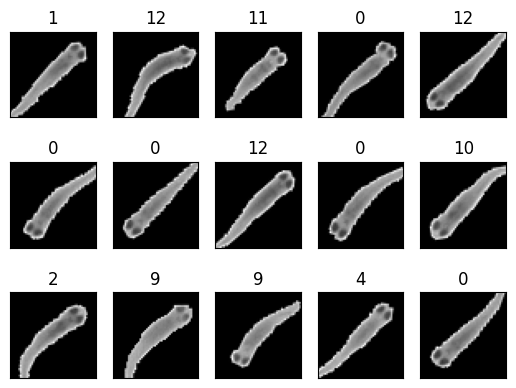

In [6]:
def show_images(images, labels):
    fig, axes_rows = plt.subplots(3, len(images) // 3)
    axes = [ax for rows in axes_rows for ax in rows]
    for image, label, ax in zip(images, labels, axes):
        ax.imshow(image, cmap="gray")
        ax.set(xticks=(), yticks=(), title=label)


# Change range here to print other images
show_images(all_images[200:215], labels=all_labels[200:215])

We divide the dataset into disjoint train/validation/test datasets

In [10]:
VALIDATION_FRAMES = 1000
TEST_FRAMES = 1000


def partition_data(
    data: np.ndarray, validation: int = VALIDATION_FRAMES, test: int = TEST_FRAMES
) -> dict[str, torch.Tensor]:
    assert validation + test < data.shape[0]
    return {
        "train": torch.tensor(data[validation:-test]),
        "validation": torch.tensor(data[:validation]),
        "test": torch.tensor(data[-test:]),
    }


labels = partition_data(all_labels)
images = partition_data(all_images)

print(
    f"Validation and test are fractions {len(images['validation']) / len(all_images):.1%} and {len(images['test']) / len(all_images):.1%}"
)

Validation and test are fractions 0.13 and 0.13


We now normalise the images to have mean 0 and standard deviation 1, using only the train data to do the mean and std computations, as mentioned in the exercises in the previous notebook.

In [11]:
def normalise(images, mean, std):
    return (images - mean) / std

In [12]:
keywords = ["train", "validation", "test"]
images_train_mean = images["train"].float().mean()
images_train_std = images["train"].float().std()

for keyword in keywords:
    images[keyword] = normalise(images[keyword], images_train_mean, images_train_std)
print(
    f"New range for train set: {images['train'].min():.2f} to {images['train'].max():.2f}"
)

New range for train set: -0.50 to 4.08


We use the TensorDataset to create a dataset from the two tensors of images and labels. We will then be able to use those datasets as dataloaders.

In [13]:
train_dataset = TensorDataset((images["train"]).float(), labels["train"])
validation_dataset = TensorDataset((images["validation"]).float(), labels["validation"])
test_dataset = TensorDataset((images["test"]).float(), labels["test"])

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=128)
validation_dataloader = DataLoader(validation_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

We begin trying with a linear network. This network is prepared to accept a list of sizes for the hidden layers and initialise itself properly. The default values can be changed on call.

In [15]:
class CARPLinearNetwork(nn.Module):
    def __init__(
        self,
        input_shape=52 * 52,
        hiden_layer_sizes=[1024, 512, 512],
        number_outputs=NUM_LABELS,
    ):
        super().__init__()

        self.layer_sizes = [input_shape] + hiden_layer_sizes + [number_outputs]

        self.linear_relu_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(
                        in_features=self.layer_sizes[i],
                        out_features=self.layer_sizes[i + 1],
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.layer_sizes) - 2)
            ]
        )

        self.output_layer = nn.Linear(
            in_features=self.layer_sizes[-2], out_features=self.layer_sizes[-1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(1)
        x = self.linear_relu_layers(x)
        x = self.output_layer(x)

        return x

In [19]:
def train_loop(
    model: nn.Module,
    epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    device,
) -> tuple[list[float], list[float], list[float], list[float]]:
    train_loss: list[float] = []
    train_acc: list[float] = []
    val_loss: list[float] = []
    val_acc: list[float] = []

    with tqdm(range(epochs), unit="epoch") as tepochs:
        tepochs.set_description("Training")
        for epoch in tepochs:
            running_loss = 0.0
            correct, total = 0, 0

            model.train()
            # Train on a batch of images
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy
                _, predicted = torch.max(output, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            # Loss and accuracy for validation dataset
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                running_loss += loss.item()

                _, predicted = torch.max(output, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            val_loss.append(running_loss / len(train_loader))
            val_acc.append(correct / total)

    return train_loss, train_acc, val_loss, val_acc

CARPLinearNetwork(
  (linear_relu_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2704, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): Linear(in_features=512, out_features=15, bias=True)
)


  0%|          | 0/50 [00:00<?, ?epoch/s]

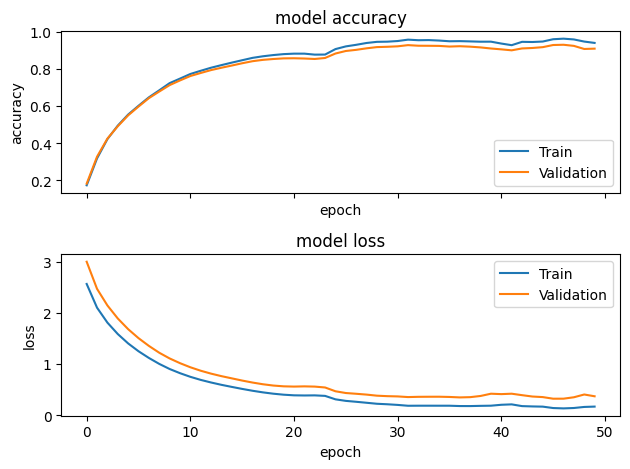

In [20]:
carp_linear = CARPLinearNetwork().to(DEVICE)
print(carp_linear)
optimizer = torch.optim.Adam(carp_linear.parameters(), lr=1e-4)

train_loss, train_acc, val_loss, val_acc = train_loop(
    carp_linear,
    epochs=50,
    optimizer=optimizer,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    loss_fn=nn.CrossEntropyLoss(),
    device=DEVICE,
)


fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_acc, label="Train")
ax1.plot(val_acc, label="Validation")
ax1.set(title="model accuracy", ylabel="accuracy", xlabel="epoch")
ax1.legend()

ax2.plot(train_loss, label="Train")
ax2.plot(val_loss, label="Validation")
ax2.set(title="model loss", ylabel="loss", xlabel="epoch")
ax2.legend()
fig.tight_layout()

In [21]:
def test(model: nn.Module, data_loader: DataLoader, device):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total += len(labels)
        correct += torch.count_nonzero(predicted == labels)

    return correct / total

In [22]:
accuracy = test(carp_linear, test_dataloader, DEVICE)
print(f"The model has a test accuracy of {accuracy:.2%}")

The model has a test accuracy of 76.20%


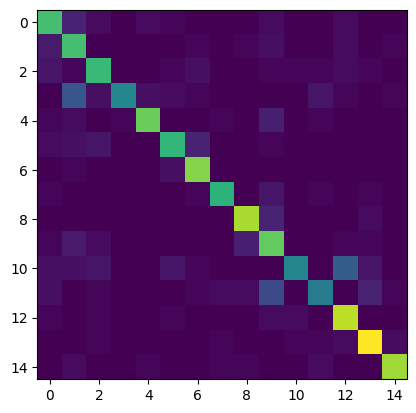

In [23]:
from sklearn.metrics import confusion_matrix


def network_confusion_matrix(model: nn.Module, data_loader: DataLoader, device):
    model.eval()
    predictions = torch.tensor([]).to(device)
    true_values = torch.tensor([]).to(device)

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        predictions = torch.cat((predictions, predicted), 0)
        true_values = torch.cat((true_values, labels), 0)

    confusion = confusion_matrix(true_values.cpu(), predictions.cpu())
    plt.imshow(confusion, interpolation="none")
    plt.show()


network_confusion_matrix(carp_linear, test_dataloader, DEVICE)

It does not seem too effective... Let us try a convolutional neural network (CNN)!

We will explain what a convolutional neural network is using the whiteboard. Then, we expect you to implement it in Pytorch (that will be **Ex 1** of this notebook). You can look at Pytorch documentation and this relevant example: https://github.com/pytorch/examples/tree/main/mnist

The input of a CNN should have shape (num images, color channels, width, height).

In [24]:
class CARPConvNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=(7, 7), padding="same"
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=(7, 7), padding="same"
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.25),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=(7, 7), padding="same"
            ),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.linear1 = nn.Sequential(
            nn.Linear(in_features=5408, out_features=512), nn.ReLU()
        )

        self.linear2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=NUM_LABELS)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1, 52, 52)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(1)
        x = self.linear1(x)
        x = self.linear2(x)

        return x

  0%|          | 0/100 [00:00<?, ?epoch/s]

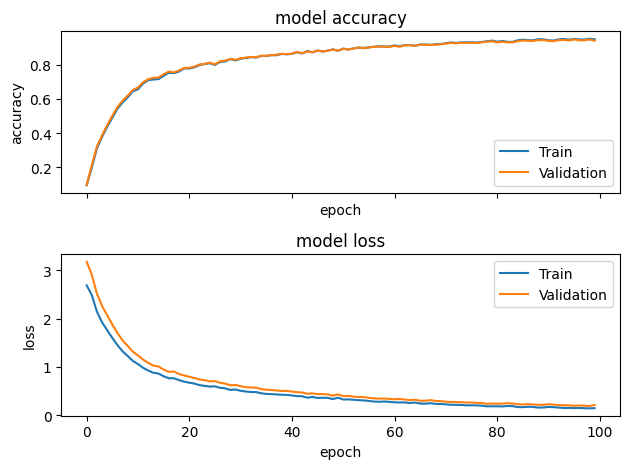

In [25]:
carp_conv = CARPConvNetwork().to(DEVICE)
optimizer = torch.optim.Adam(params=carp_conv.parameters(), lr=1e-4)


train_loss, train_acc, val_loss, val_acc = train_loop(
    carp_conv,
    epochs=100,
    optimizer=optimizer,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    loss_fn=nn.CrossEntropyLoss(),
    device=DEVICE,
)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_acc, label="Train")
ax1.plot(val_acc, label="Validation")
ax1.set(title="model accuracy", ylabel="accuracy", xlabel="epoch")
ax1.legend()

ax2.plot(train_loss, label="Train")
ax2.plot(val_loss, label="Validation")
ax2.set(title="model loss", ylabel="loss", xlabel="epoch")
ax2.legend()
fig.tight_layout()

In [26]:
accuracy = test(carp_conv, test_dataloader, DEVICE)
print(f"The model has a test accuracy of {accuracy:.2%}")

The model has a test accuracy of 92.60%


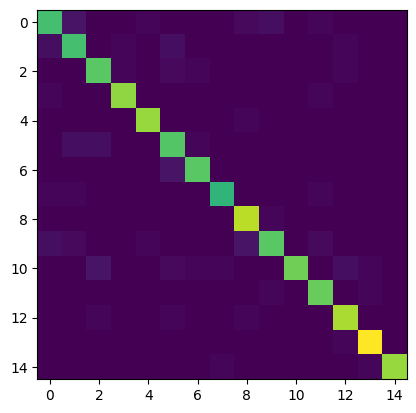

In [27]:
network_confusion_matrix(carp_conv, test_dataloader, DEVICE)

We see a significantly higher accuracy on the test data when using a CNN.